In [1]:
import os
from pathlib import Path

from itertools import chain

import datetime

import math
import numpy as np
import pandas as pd

from matplotlib import cm
import matplotlib.pyplot as plt
import seaborn as sns

# https://github.com/reichlab/timeseriesutils
from timeseriesutils import featurize

In [9]:
def load_data(pathogen):
    path = max(Path('data').glob(f'{pathogen}_data_cached_*.csv'))
    df = pd.read_csv(path)
    
    df = df.loc[(df['date'] >= '2021-02-28') & (df['date'] <='2022-08-31')]
    df['date'] = pd.to_datetime(df['date'])
    
    # log population -- a feature, but used in plots immediately below
    df['log_tot_samples'] = np.log(df['total_samples'])
    
    # process response variable:
    # - replace low values with 0.1, selected by looking at plots
    # - fourth root transform to stabilize variability
    # - divide by location-specific 95th percentile
    # - center relative to location-specific mean
    #   (note non-standard order of center/scale)
    df['clade_rate_4rt'] = df['clade_pct']
    # have to check what to do with the below
    #df.loc[df['clade_pct'] < 0.1, 'clade_pct'] = 0.1
    df['clade_rate_4rt'] = df['clade_rate_4rt'] ** 0.25
    df['clade_rate_4rt_scale_factor'] = df \
        .groupby('Nextstrain_clade')['clade_rate_4rt'] \
        .transform(lambda x: x.quantile(0.95))
    # manual adjustment to scale factor for pathogen == 'influenza'
    # we have limited historical data, from an unusually small season
    # inflate scaling factor by 10, which is the ratio of peak weekly
    # rate from flusurv last season vs the previous largest flusurv season
    # if pathogen == 'flu':
    #    df['hosp_rate_4rt_scale_factor'] = df['hosp_rate_4rt_scale_factor'] * 10.0
    #
    df['clade_rate_4rt_cs'] = df['clade_rate_4rt'] / (df['clade_rate_4rt_scale_factor'] + 0.01)
    df['clade_rate_4rt_center_factor'] = df \
        .groupby('Nextstrain_clade')['clade_rate_4rt_cs'] \
        .transform(lambda x: x.mean())
    df['clade_rate_4rt_cs'] = df['clade_rate_4rt_cs'] - df['clade_rate_4rt_center_factor']
    # growth rates
    df['growth_rate_4rt'] = df['diff_log']
    # have to check what to do with the below
    #df.loc[df['clade_pct'] < 0.1, 'clade_pct'] = 0.1
    df['growth_rate_4rt'] = df['growth_rate_4rt'] ** 0.25
    df['growth_rate_4rt_scale_factor'] = df \
        .groupby('Nextstrain_clade')['growth_rate_4rt'] \
        .transform(lambda x: x.quantile(0.95))
    df['growth_rate_4rt_cs'] = df['growth_rate_4rt'] / (df['growth_rate_4rt_scale_factor'] + 0.01)
    df['growth_rate_4rt_center_factor'] = df \
        .groupby('Nextstrain_clade')['growth_rate_4rt_cs'] \
        .transform(lambda x: x.mean())
    df['growth_rate_4rt_cs'] = df['growth_rate_4rt_cs'] - df['growth_rate_4rt_center_factor']
    # indicator of which pathogen
    # df['pathogen_covid'] = int(pathogen == 'covid')
    
    return(df) 

           date  clade_samples  total_samples Nextstrain_clade  clade_pct  \
837  2021-02-28              4             64              20A   0.062500   
838  2021-02-28             11             64              20B   0.171875   
839  2021-02-28             20             64              20C   0.312500   
840  2021-02-28             13             64              20G   0.203125   
841  2021-02-28             11             64  20I (Alpha, V1)   0.171875   
...         ...            ...            ...              ...        ...   
3510 2022-08-30             66             85    22B (Omicron)   0.776471   
3511 2022-08-30              1             85      recombinant   0.011765   
3512 2022-08-31              7             52    22A (Omicron)   0.134615   
3513 2022-08-31             44             52    22B (Omicron)   0.846154   
3514 2022-08-31              1             52    22C (Omicron)   0.019231   

      diff_log  nonvar_diff_log  log_tot_samples  clade_rate_4rt  \
837   0

<Axes: xlabel='date', ylabel='clade_rate_4rt_cs'>

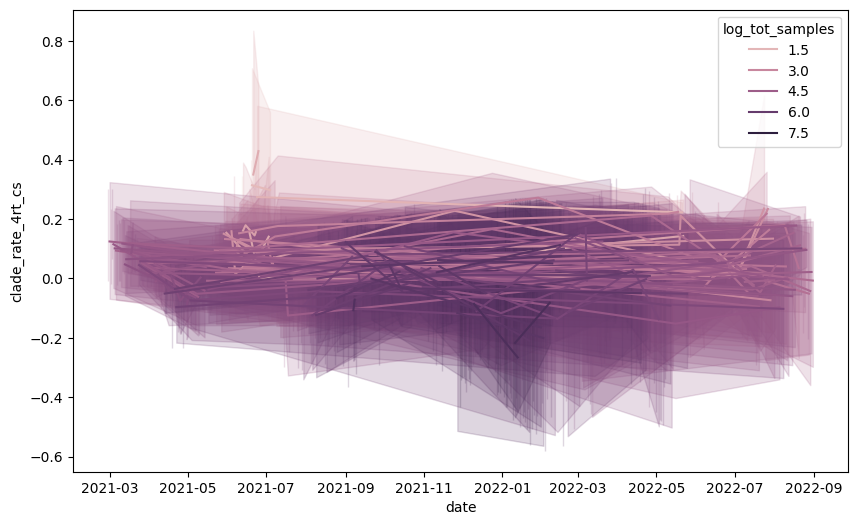

In [10]:
clade_df = load_data(pathogen='clade')
print(clade_df)

fig, ax = plt.subplots()
fig.set_size_inches(10, 6)
sns.lineplot(data=clade_df, x='date', y='clade_rate_4rt_cs', hue='log_tot_samples', ax=ax)

<Axes: xlabel='date', ylabel='growth_rate_4rt_cs'>

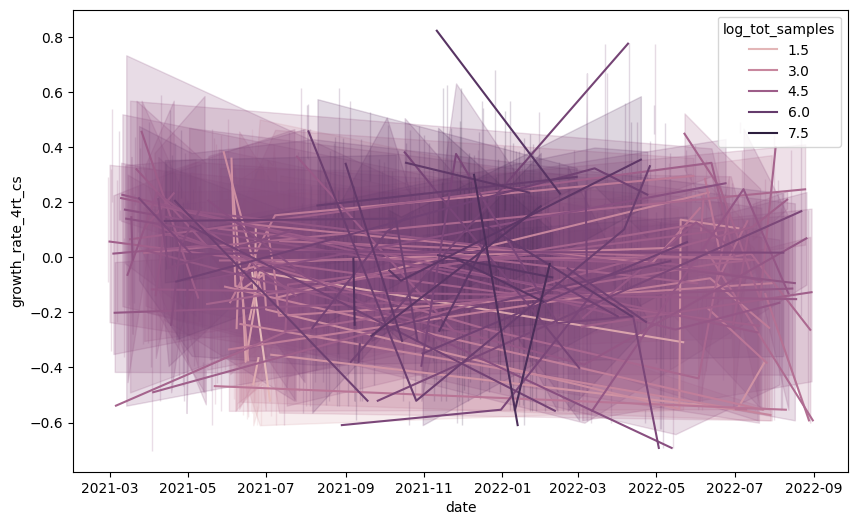

In [11]:
fig1, ax = plt.subplots()
fig1.set_size_inches(10, 6)
sns.lineplot(data=clade_df, x='date', y='growth_rate_4rt_cs', hue='log_tot_samples', ax=ax)

# Calculate features

### Misc. features based on date and clade variables

In [13]:
# we previously calculated log population and
# an indicator of whether the pathogen is covid
# feat_names = ['log_pop', 'pathogen_covid']
feat_names = ['log_pop']

# one-hot encodings of day of week and location
clade_df['dow'] = pd.to_datetime(clade_df.date).dt.dayofweek

for c in ['Nextstrain_clade', 'dow']:
    ohe = pd.get_dummies(clade_df[c], prefix=c)
    clade_df = pd.concat([clade_df, ohe], axis=1)
    feat_names = feat_names + list(ohe.columns)

feat_names

['log_pop',
 'Nextstrain_clade_19A',
 'Nextstrain_clade_19B',
 'Nextstrain_clade_20A',
 'Nextstrain_clade_20B',
 'Nextstrain_clade_20C',
 'Nextstrain_clade_20D',
 'Nextstrain_clade_20G',
 'Nextstrain_clade_20H (Beta, V2)',
 'Nextstrain_clade_20I (Alpha, V1)',
 'Nextstrain_clade_20J (Gamma, V3)',
 'Nextstrain_clade_21A (Delta)',
 'Nextstrain_clade_21B (Kappa)',
 'Nextstrain_clade_21C (Epsilon)',
 'Nextstrain_clade_21D (Eta)',
 'Nextstrain_clade_21F (Iota)',
 'Nextstrain_clade_21G (Lambda)',
 'Nextstrain_clade_21H (Mu)',
 'Nextstrain_clade_21I (Delta)',
 'Nextstrain_clade_21J (Delta)',
 'Nextstrain_clade_21K (Omicron)',
 'Nextstrain_clade_21L (Omicron)',
 'Nextstrain_clade_21M (Omicron)',
 'Nextstrain_clade_22A (Omicron)',
 'Nextstrain_clade_22B (Omicron)',
 'Nextstrain_clade_22C (Omicron)',
 'Nextstrain_clade_22D (Omicron)',
 'Nextstrain_clade_recombinant',
 'dow_0',
 'dow_1',
 'dow_2',
 'dow_3',
 'dow_4',
 'dow_5',
 'dow_6']

### Features summarizing time series within each location

In [30]:
clade_df, new_feat_names = featurize.featurize_data(
    clade_df, group_columns=['location', 'pathogen_covid'],
    features = [
        {
            'fun': 'windowed_taylor_coefs',
            'args': {
                'columns': 'hosp_rate_4rt_cs',
                'taylor_degree': 2,
                'window_align': 'trailing',
                'window_size': [28, 42],
                'fill_edges': False
            }
        },
        {
            'fun': 'windowed_taylor_coefs',
            'args': {
                'columns': 'hosp_rate_4rt_cs',
                'taylor_degree': 1,
                'window_align': 'trailing',
                'window_size': [14],
                'fill_edges': False
            }
        },
        {
            'fun': 'rollmean',
            'args': {
                'columns': 'hosp_rate_4rt_cs',
                'group_columns': ['location'],
                'window_size': [7, 14]
            }
        }
    ])
feat_names = feat_names + new_feat_names

df, new_feat_names = featurize.featurize_data(
    df, group_columns=['location', 'pathogen_covid'],
    features = [
        {
            'fun': 'lag',
            'args': {
                'columns': new_feat_names,
                'lags': [7, 14]
            }
        }
    ])
feat_names = feat_names + new_feat_names

df['empirical_deriv'] = (df['hosp_rate_4rt_cs_rollmean_w7'] - df['hosp_rate_4rt_cs_rollmean_w7_lag7']) / 7
feat_names =feat_names + ['empirical_deriv']

print(df)
print(feat_names)

      location       date   hosps  location_name  population     pop100k  \
0           01 2020-12-01   285.0        Alabama     4903185    49.03185   
1           01 2020-12-02   294.0        Alabama     4903185    49.03185   
2           01 2020-12-03   279.0        Alabama     4903185    49.03185   
3           01 2020-12-04   294.0        Alabama     4903185    49.03185   
4           01 2020-12-05   272.0        Alabama     4903185    49.03185   
...        ...        ...     ...            ...         ...         ...   
55427       US 2022-12-07  5384.0  United States   332875137  3328.75137   
55428       US 2022-12-08  3279.0  United States   332875137  3328.75137   
55429       US 2022-12-08  5208.0  United States   332875137  3328.75137   
55430       US 2022-12-09  3209.0  United States   332875137  3328.75137   
55431       US 2022-12-09  5218.0  United States   332875137  3328.75137   

       hosp_rate    log_pop  hosp_rate_4rt  hosp_rate_4rt_scale_factor  ...  \
0       

In [31]:
# drop features that involve absolute level
# feat_names = ['log_pop', 'pathogen_covid', 'location_01', 'location_02', 'location_04',
feat_names = ['log_pop', 'location_01', 'location_02', 'location_04',
    'location_05', 'location_06', 'location_08', 'location_09', 'location_10', 'location_11',
    'location_12', 'location_13', 'location_15', 'location_16', 'location_17', 'location_18',
    'location_19', 'location_20', 'location_21', 'location_22', 'location_23', 'location_24',
    'location_25', 'location_26', 'location_27', 'location_28', 'location_29', 'location_30',
    'location_31', 'location_32', 'location_33', 'location_34', 'location_35', 'location_36',
    'location_37', 'location_38', 'location_39', 'location_40', 'location_41', 'location_42',
    'location_44', 'location_45', 'location_46', 'location_47', 'location_48', 'location_49',
    'location_50', 'location_51', 'location_53', 'location_54', 'location_55', 'location_56',
    'location_60', 'location_72', 'location_78', 'location_US', 'dow_0', 'dow_1', 'dow_2',
    'dow_3', 'dow_4', 'dow_5', 'dow_6', 'hosp_rate_4rt_cs_taylor_d1_w28t_sNone',
    'hosp_rate_4rt_cs_taylor_d2_w28t_sNone', 'hosp_rate_4rt_cs_taylor_d1_w42t_sNone',
    'hosp_rate_4rt_cs_taylor_d2_w42t_sNone', 'hosp_rate_4rt_cs_taylor_d1_w14t_sNone',
    'hosp_rate_4rt_cs_taylor_d1_w28t_sNone_lag7', 'hosp_rate_4rt_cs_taylor_d1_w28t_sNone_lag14',
    'hosp_rate_4rt_cs_taylor_d2_w28t_sNone_lag7', 'hosp_rate_4rt_cs_taylor_d2_w28t_sNone_lag14',
    'hosp_rate_4rt_cs_taylor_d1_w42t_sNone_lag7', 'hosp_rate_4rt_cs_taylor_d1_w42t_sNone_lag14',
    'hosp_rate_4rt_cs_taylor_d2_w42t_sNone_lag7', 'hosp_rate_4rt_cs_taylor_d2_w42t_sNone_lag14',
    'hosp_rate_4rt_cs_taylor_d1_w14t_sNone_lag7', 'hosp_rate_4rt_cs_taylor_d1_w14t_sNone_lag14',
    'empirical_deriv']

In [32]:
# import importlib
# featurize = importlib.reload(featurize)

# figure out horizons
# last date with observed data
last_obs_date = pd.to_datetime(df.groupby(['location', 'pathogen_covid'])['date'].max().min())
print(f'last_obs_date: {last_obs_date}')

# how far out to forecast to get to 28 days after due date
due_date = forecast_date
extra_horizons_rel_obs = (due_date - last_obs_date.date()).days
effective_horizon_rel_obs = max_horizon + extra_horizons_rel_obs

# add forecast targets
df_with_pred_targets, new_feat_names = featurize.featurize_data(
    df, group_columns=['location', 'pathogen_covid'],
    features = [
        {
            'fun': 'horizon_targets',
            'args': {
                'columns': 'hosp_rate_4rt_cs',
                'horizons': [(i+1) for i in range(effective_horizon_rel_obs)]
            }
        }
    ])
feat_names = feat_names + new_feat_names

# we will model the differences between the prediction target and the most
# recent observed value
df_with_pred_targets['delta_target'] = df_with_pred_targets['hosp_rate_4rt_cs_target'] - df_with_pred_targets['hosp_rate_4rt_cs_taylor_d0_w42t_sNone']

print(new_feat_names)
print(df_with_pred_targets)

last_obs_date: 2022-12-09 00:00:00
['horizon']
      location       date   hosps  location_name  population     pop100k  \
0           01 2020-12-01   285.0        Alabama     4903185    49.03185   
1           01 2020-12-02   294.0        Alabama     4903185    49.03185   
2           01 2020-12-03   279.0        Alabama     4903185    49.03185   
3           01 2020-12-04   294.0        Alabama     4903185    49.03185   
4           01 2020-12-05   272.0        Alabama     4903185    49.03185   
...        ...        ...     ...            ...         ...         ...   
55427       US 2022-12-07  5384.0  United States   332875137  3328.75137   
55428       US 2022-12-08  3279.0  United States   332875137  3328.75137   
55429       US 2022-12-08  5208.0  United States   332875137  3328.75137   
55430       US 2022-12-09  3209.0  United States   332875137  3328.75137   
55431       US 2022-12-09  5218.0  United States   332875137  3328.75137   

       hosp_rate    log_pop  hosp_rate_4

In [ ]:
list(df_with_pred_targets.columns)

In [33]:
df_with_pred_targets['horizon']

0         1
1         1
2         1
3         1
4         1
         ..
55427    31
55428    31
55429    31
55430    31
55431    31
Name: horizon, Length: 1718392, dtype: int64

In [34]:
# drop rows with missing feature values
# these show up for early dates and American Samoa
drop_rows = (np.sum(np.isnan(df_with_pred_targets.loc[:, feat_names]), axis=1) > 0).values
print(df_with_pred_targets.loc[drop_rows].date.unique())
print(df_with_pred_targets.loc[drop_rows & (df_with_pred_targets.date >= '2021-08-23')].location_name.unique())

df_with_pred_targets = df_with_pred_targets.loc[~drop_rows]

['2020-12-01T00:00:00.000000000' '2020-12-02T00:00:00.000000000'
 '2020-12-03T00:00:00.000000000' '2020-12-04T00:00:00.000000000'
 '2020-12-05T00:00:00.000000000' '2020-12-06T00:00:00.000000000'
 '2020-12-07T00:00:00.000000000' '2020-12-08T00:00:00.000000000'
 '2020-12-09T00:00:00.000000000' '2020-12-10T00:00:00.000000000'
 '2020-12-11T00:00:00.000000000' '2020-12-12T00:00:00.000000000'
 '2020-12-13T00:00:00.000000000' '2020-12-14T00:00:00.000000000'
 '2020-12-15T00:00:00.000000000' '2020-12-16T00:00:00.000000000'
 '2020-12-17T00:00:00.000000000' '2020-12-18T00:00:00.000000000'
 '2020-12-19T00:00:00.000000000' '2020-12-20T00:00:00.000000000'
 '2020-12-21T00:00:00.000000000' '2020-12-22T00:00:00.000000000'
 '2020-12-23T00:00:00.000000000' '2020-12-24T00:00:00.000000000'
 '2020-12-25T00:00:00.000000000' '2020-12-26T00:00:00.000000000'
 '2020-12-27T00:00:00.000000000' '2020-12-28T00:00:00.000000000'
 '2020-12-29T00:00:00.000000000' '2020-12-30T00:00:00.000000000'
 '2020-12-31T00:00:00.000